<a href="https://colab.research.google.com/github/kitkeat/Effective-Argument-Prediction-NLP/blob/main/1-datacleaning-eda.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Book 1 - Data Cleaning and EDA

---

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.tokenize import sent_tokenize
import nltk
nltk.download('punkt')
import re
from IPython.core.display import display, HTML
import spacy
from spacy import displacy
from text_unidecode import unidecode
from typing import Dict, List, Tuple
import codecs

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
train = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Data/train.csv')
df = train.copy()

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36765 entries, 0 to 36764
Data columns (total 5 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   discourse_id             36765 non-null  object
 1   essay_id                 36765 non-null  object
 2   discourse_text           36765 non-null  object
 3   discourse_type           36765 non-null  object
 4   discourse_effectiveness  36765 non-null  object
dtypes: object(5)
memory usage: 1.4+ MB


In [7]:
df.describe()

,discourse_id,essay_id,discourse_text,discourse_type,discourse_effectiveness
count,36765,36765,36765,36765,36765
unique,36765,4191,36691,7,3
top,0013cc385424,91B1F82B2CF1,Summer projects should be student-designed,Evidence,Adequate
freq,1,23,14,12105,20977


In [9]:
df.head()

,discourse_id,essay_id,discourse_text,discourse_type,discourse_effectiveness
0,0013cc385424,007ACE74B050,"Hi, i'm Isaac, i'm going to be writing about h...",Lead,Adequate
1,9704a709b505,007ACE74B050,"On my perspective, I think that the face is a ...",Position,Adequate
2,c22adee811b6,007ACE74B050,I think that the face is a natural landform be...,Claim,Adequate
3,a10d361e54e4,007ACE74B050,"If life was on Mars, we would know by now. The...",Evidence,Adequate
4,db3e453ec4e2,007ACE74B050,People thought that the face was formed by ali...,Counterclaim,Adequate


## Discourse Type
Each essay element contains discourse type metadata. There are 7 discourse_type values with explainations:

`Lead` - an introduction that begins with a statistic, a quotation, a description, or some other device to grab the reader’s attention and point toward the thesis

`Position` - an opinion or conclusion on the main question

`Claim` - a claim that supports the position

`Counterclaim` - a claim that refutes another claim or gives an opposing reason to the position

`Rebuttal` - a claim that refutes a counterclaim

`Evidence` - ideas or examples that support claims, counterclaims, or rebuttals.

`Concluding Statement` - a concluding statement that restates the claims.

# Data Cleaning

---

Wrong spellings are ignored and important for the model training. This includes the special characteres such as exclamation marks and fullstops.

## Normalize unicode

In [10]:
# https://www.kaggle.com/competitions/feedback-prize-2021/discussion/313330
def replace_encoding_with_utf8(error: UnicodeError) -> Tuple[bytes, int]:
    return error.object[error.start : error.end].encode("utf-8"), error.end


def replace_decoding_with_cp1252(error: UnicodeError) -> Tuple[str, int]:
    return error.object[error.start : error.end].decode("cp1252"), error.end

# Register the encoding and decoding error handlers for `utf-8` and `cp1252`.
codecs.register_error("replace_encoding_with_utf8", replace_encoding_with_utf8)
codecs.register_error("replace_decoding_with_cp1252", replace_decoding_with_cp1252)

def resolve_encodings_and_normalize(text: str) -> str:
    """Resolve the encoding problems and normalize the abnormal characters."""
    text = (
        text.encode("raw_unicode_escape")
        .decode("utf-8", errors="replace_decoding_with_cp1252")
        .encode("cp1252", errors="replace_encoding_with_utf8")
        .decode("utf-8", errors="replace_decoding_with_cp1252")
    )
    text = unidecode(text)
    return text


In [11]:
df['discourse_text_norm'] = df['discourse_text'].apply(resolve_encodings_and_normalize)

In [12]:
# sample = df.sample(1)['discourse_id'].values[0]
# print(sample)
sample = '451b76cc4b59'
text = df.loc[(df['discourse_id']==sample),'discourse_text'].values[0]
text_norm = df.loc[(df['discourse_id']==sample),'discourse_text_norm'].values[0]
print(f'Discourse_id: {sample}')
print()
text
# print(text_norm)

Discourse_id: 451b76cc4b59



'After all, many students will greduate and keep going with their life without having any problem about jobs and they will be good economically. They also will give their childs a reason why they should go to school and follow their dreams without letting people to\xa0punish their\xa0dreams. It also will help their family to support them without caring about what other people says, but everyone should conserve good things about everything. Also this students will have an illustrate part of his life, where they are going from success to success keeping everything on the side but his dreams on the front.   \xa0 \xa0 \xa0 '

In [13]:
text_norm

'After all, many students will greduate and keep going with their life without having any problem about jobs and they will be good economically. They also will give their childs a reason why they should go to school and follow their dreams without letting people to punish their dreams. It also will help their family to support them without caring about what other people says, but everyone should conserve good things about everything. Also this students will have an illustrate part of his life, where they are going from success to success keeping everything on the side but his dreams on the front.         '

# EDA

---

## Discourse Text and Type Analysis

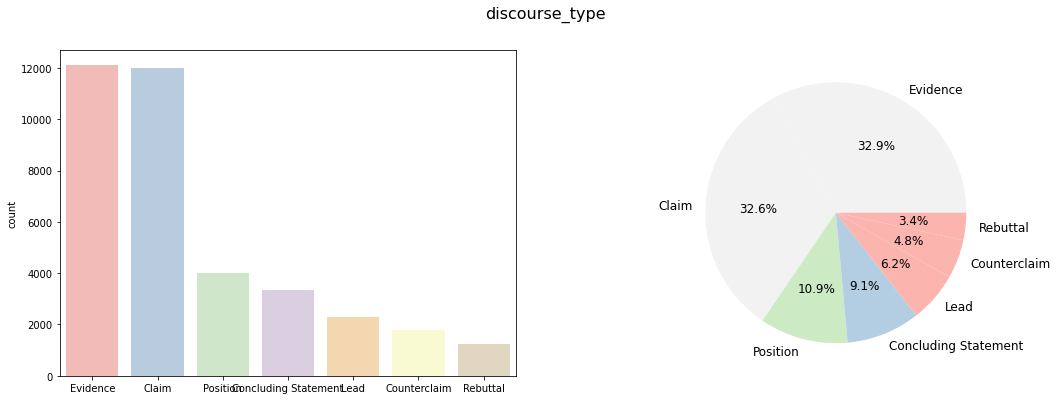

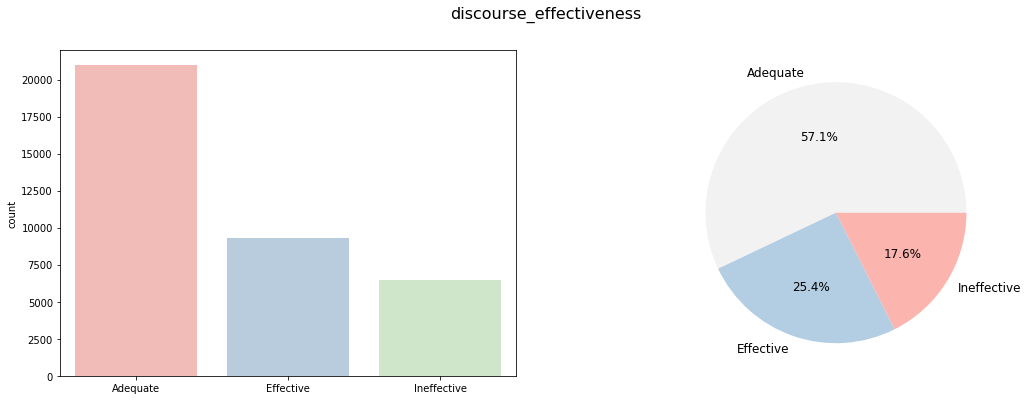

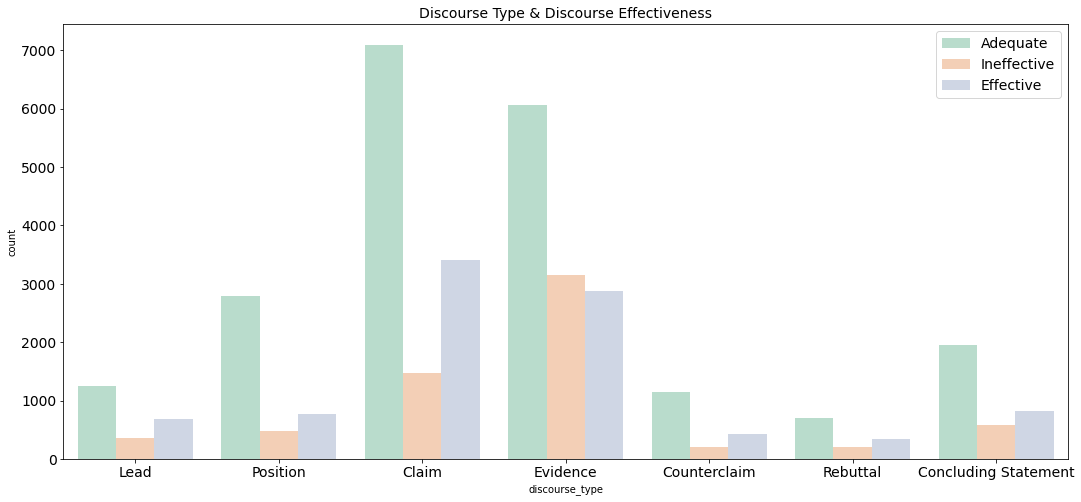

In [14]:
def cat_analyser(data, col):
    fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (18, 6))
    fig.suptitle(col, fontsize = 16)
    sns.countplot(data = data,
                  x = col,
                  ax = ax[0],
                  palette= 'Pastel1',
                  order =  data[col].value_counts().index)
    ax[0].set_xlabel('')
    pie_cmap = plt.get_cmap('Pastel1')
    normalize = lambda x: (x - np.min(x)) / (np.max(x) - np.min(x)) 
    data[col].value_counts().plot.pie(autopct='%1.1f%%',
                                      textprops={'fontsize': 12},
                                      ax=ax[1],
                                      colors = pie_cmap(normalize(data[col].value_counts())))
    ax[1].set_ylabel('')
    plt.show()
    
for col in ['discourse_type', 'discourse_effectiveness']:
    cat_analyser(df, col)
    
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize=(18, 8))
sns.countplot(data = df,
              x = 'discourse_type',
              hue ='discourse_effectiveness',
              palette = 'Pastel2')
plt.legend(loc = 'best', prop={'size': 14})
plt.title('Discourse Type & Discourse Effectiveness', size = 14)
plt.yticks(size = 14)
plt.xticks(size = 14)
plt.show()

## Number of sentences per row of data

Finding: Some rows have more than one sentences.

In [15]:
text = [len(sent_tokenize(text=row,language = 'english')) for row in df['discourse_text']]
sentence = pd.DataFrame(text)
df['text_num_sentence'] = sentence

In [16]:
# Including special characters
df['text_word_count'] = df['discourse_text'].str.split().apply(len)
df['text_char_count'] = df['discourse_text'].apply(len)

def num_specialchar(row):
    new = re.sub('[\w]+' ,'', row)
    return len(new)

df['text_num_special_char']=df['discourse_text'].apply(num_specialchar)

,count,mean,std,min,25%,50%,75%,max
discourse_effectiveness,,,,,,,,
Adequate,20977.0,1.904228,1.591156,1.0,1.0,1.0,2.0,41.0
Effective,9326.0,3.011581,2.699871,1.0,1.0,2.0,4.0,37.0
Ineffective,6462.0,2.488548,2.963552,1.0,1.0,1.0,3.0,40.0


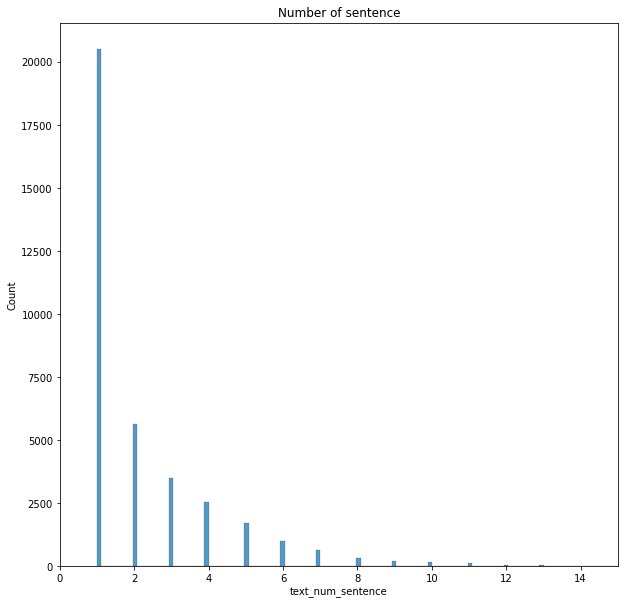

In [17]:
plt.figure(figsize=(10,10))
sns.histplot(data=df, x ='text_num_sentence')
plt.title('Number of sentence')
plt.xlim(0,15)
df.groupby('discourse_effectiveness')['text_num_sentence'].describe()

## Number of words per row of data

Findings: Effective sentences tend to have more words, followed by ineffective and adequate.

,count,mean,std,min,25%,50%,75%,max
discourse_effectiveness,,,,,,,,
Adequate,20977.0,35.120275,31.567374,1.0,14.0,24.0,46.0,519.0
Effective,9326.0,63.269354,57.978461,1.0,19.0,39.0,96.0,542.0
Ineffective,6462.0,48.737078,59.116275,1.0,17.0,30.0,57.0,836.0


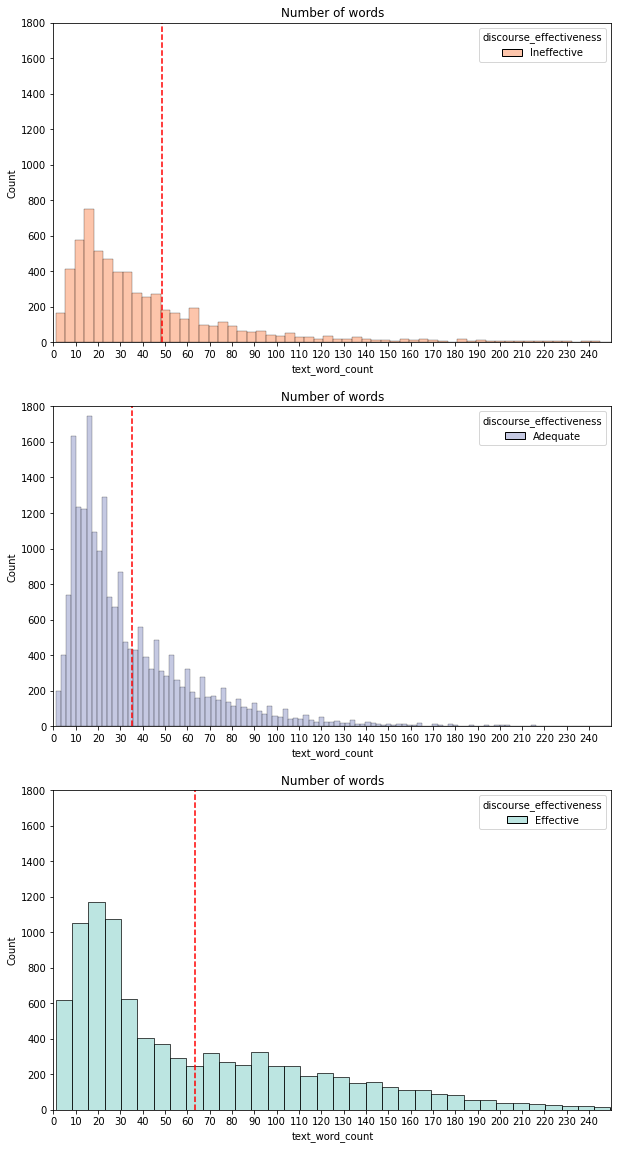

In [23]:
ineff_word = df.loc[df['discourse_effectiveness']=='Ineffective']
eff_word = df.loc[df['discourse_effectiveness']=='Effective']
adq_word = df.loc[df['discourse_effectiveness']=='Adequate']

figs, axs = plt.subplots(3,1,figsize=(10,20))
# plt.figure(figsize=(10,10))
sns.histplot(data=ineff_word, x ='text_word_count',hue='discourse_effectiveness',ax=axs[0],palette = 'OrRd')
sns.histplot(data=adq_word, x ='text_word_count',hue='discourse_effectiveness',ax=axs[1],palette = 'BuPu')
sns.histplot(data=eff_word, x ='text_word_count',hue='discourse_effectiveness',ax=axs[2],palette = 'GnBu')
axs[0].set_title('Number of words')
axs[1].set_title('Number of words')
axs[2].set_title('Number of words')
axs[0].set_xlim(0,250)
axs[1].set_xlim(0,250)
axs[2].set_xlim(0,250)
axs[0].set_ylim(0,1800)
axs[1].set_ylim(0,1800)
axs[2].set_ylim(0,1800)
axs[0].axvline(x=ineff_word['text_word_count'].mean(),color='red',linestyle='--')
axs[1].axvline(x=adq_word['text_word_count'].mean(),color='red',linestyle='--')
axs[2].axvline(x=eff_word['text_word_count'].mean(),color='red',linestyle='--')
axs[0].xaxis.set_ticks(np.arange(0, 250, 10))
axs[1].xaxis.set_ticks(np.arange(0, 250, 10))
axs[2].xaxis.set_ticks(np.arange(0, 250, 10));

df.groupby('discourse_effectiveness')['text_word_count'].describe()


## Number of Characters per text

Findings: Effective text has the highest average number of characters, followed by Ineffective and Adequate. This may pose a great problem to identify between Ineffective and adequate

,count,mean,std,min,25%,50%,75%,max
discourse_effectiveness,,,,,,,,
Adequate,20977.0,193.231587,173.533538,6.0,80.0,134.0,255.00,3031.0
Effective,9326.0,363.642612,330.738540,7.0,114.0,225.0,553.00,2924.0
Ineffective,6462.0,266.401578,327.915032,4.0,90.0,161.0,306.75,4099.0


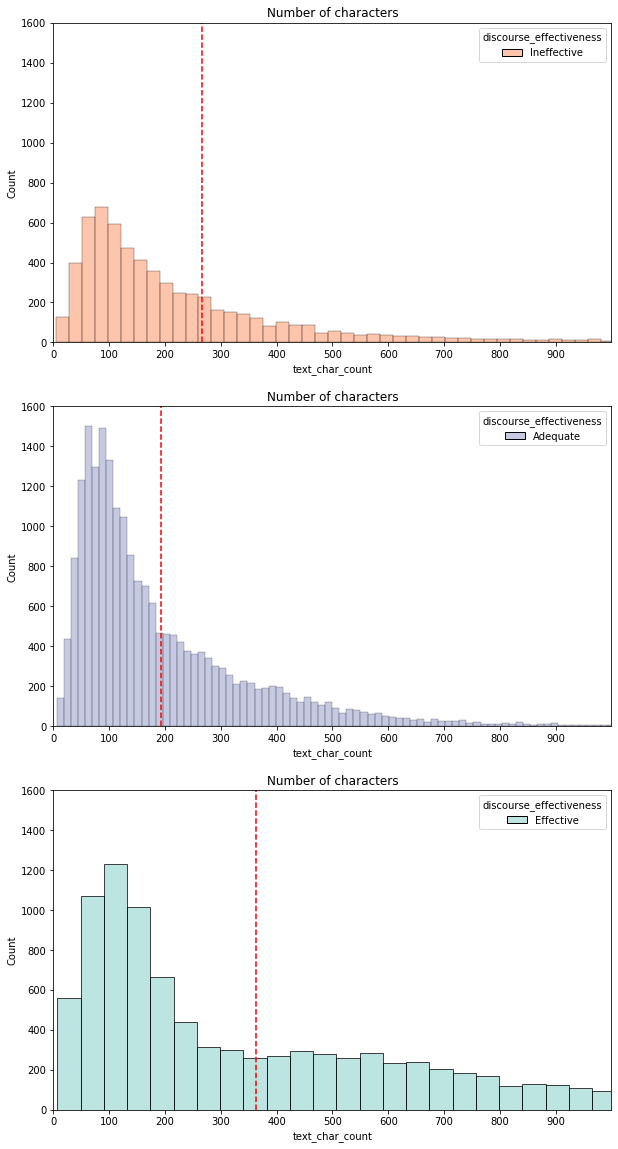

In [24]:
figs, axs = plt.subplots(3,1,figsize=(10,20))
# plt.figure(figsize=(10,10))
sns.histplot(data=ineff_word, x ='text_char_count',hue='discourse_effectiveness',ax=axs[0],palette = 'OrRd')
sns.histplot(data=adq_word, x ='text_char_count',hue='discourse_effectiveness',ax=axs[1],palette = 'BuPu')
sns.histplot(data=eff_word, x ='text_char_count',hue='discourse_effectiveness',ax=axs[2],palette = 'GnBu')
axs[0].set_title('Number of characters')
axs[1].set_title('Number of characters')
axs[2].set_title('Number of characters')
axs[0].set_xlim(0,1000)
axs[1].set_xlim(0,1000)
axs[2].set_xlim(0,1000)
axs[0].set_ylim(0,1600)
axs[1].set_ylim(0,1600)
axs[2].set_ylim(0,1600)
axs[0].axvline(x=ineff_word['text_char_count'].mean(),color='red',linestyle='--')
axs[1].axvline(x=adq_word['text_char_count'].mean(),color='red',linestyle='--')
axs[2].axvline(x=eff_word['text_char_count'].mean(),color='red',linestyle='--')
axs[0].xaxis.set_ticks(np.arange(0, 1000, 100))
axs[1].xaxis.set_ticks(np.arange(0, 1000, 100))
axs[2].xaxis.set_ticks(np.arange(0, 1000, 100));

df.groupby('discourse_effectiveness')['text_char_count'].describe()

,count,mean,std,min,25%,50%,75%,max
discourse_effectiveness,,,,,,,,
Adequate,20977.0,38.946036,35.480854,1.0,15.0,27.0,52.0,597.0
Effective,9326.0,70.563693,65.016122,1.0,21.0,44.0,108.0,631.0
Ineffective,6462.0,54.298514,66.694304,1.0,18.0,33.0,63.0,879.0


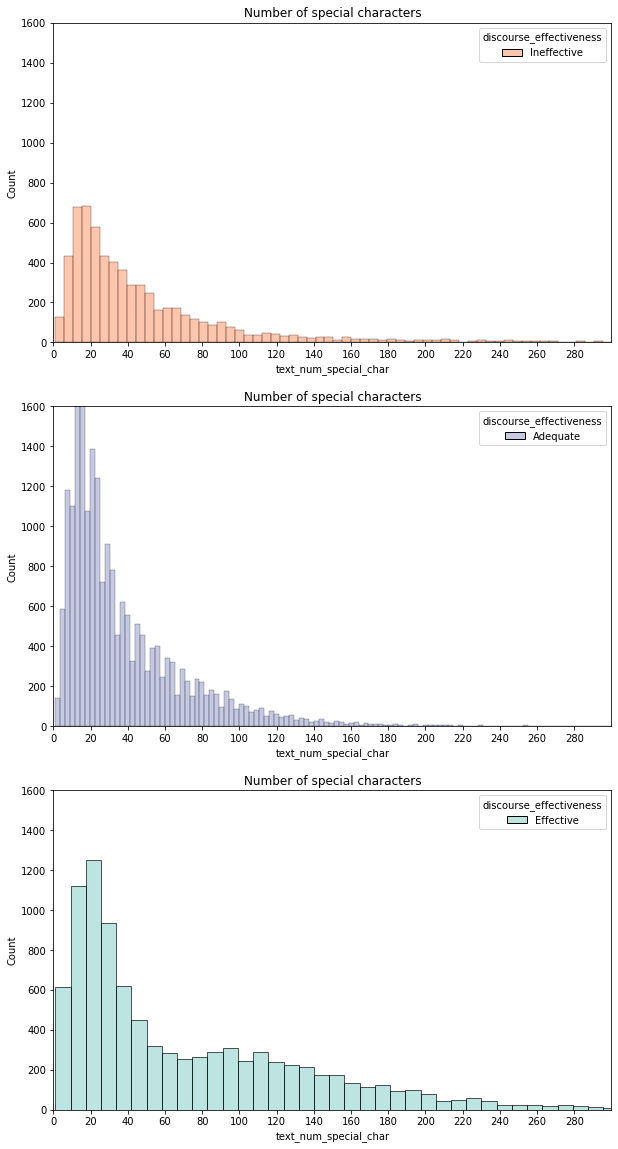

In [ ]:
figs, axs = plt.subplots(3,1,figsize=(10,20))
# plt.figure(figsize=(10,10))
sns.histplot(data=ineff_word, x ='text_num_special_char',hue='discourse_effectiveness',ax=axs[0],palette = 'OrRd')
sns.histplot(data=adq_word, x ='text_num_special_char',hue='discourse_effectiveness',ax=axs[1],palette = 'BuPu')
sns.histplot(data=eff_word, x ='text_num_special_char',hue='discourse_effectiveness',ax=axs[2],palette = 'GnBu')
axs[0].set_title('Number of special characters')
axs[1].set_title('Number of special characters')
axs[2].set_title('Number of special characters')
axs[0].set_xlim(0,300)
axs[1].set_xlim(0,300)
axs[2].set_xlim(0,300)
axs[0].set_ylim(0,1600)
axs[1].set_ylim(0,1600)
axs[2].set_ylim(0,1600)

axs[0].xaxis.set_ticks(np.arange(0, 300, 20))
axs[1].xaxis.set_ticks(np.arange(0, 300, 20))
axs[2].xaxis.set_ticks(np.arange(0, 300, 20));

df.groupby('discourse_effectiveness')['text_num_special_char'].describe()

## Number of essays

Findings: The number of unique essays are relatively low, incomparison with the total data size.

In [ ]:
df.groupby(['essay_id']).nunique().shape

(4191, 9)

## Read an example of the essay, together with the type and effectiveness

In [ ]:
def get_text(ids):
    with open(f'../input/feedback-prize-effectiveness/train/{ids}.txt', 'r') as file: data = file.read()
    return data

def display_sample(essay_id):
#     text = get_text(essay_id)
#     text = resolve_encodings_and_normalize(text)
    # ex = []
    char_pos = 0
    ex = [{"text": '',"ents": [],'title':''}]
    ex2 = [{"text": '',"ents": []}]
    text = ''
    for idx in range(df.loc[df['essay_id']=='331CA007D0AD'].shape[0]):
        
        discourse_text = df[(df.essay_id == essay_id)]['discourse_text'].values[idx]
        discourse_text = resolve_encodings_and_normalize(discourse_text)
        begin = char_pos
        end = begin + len(discourse_text)
        # begin = char_pos
        # end = begin + len(discourse_text)
        discoursetype = df[(df.essay_id == essay_id)]['discourse_type'].values[idx]
        label = df[(df.essay_id == essay_id)]['discourse_effectiveness'].values[idx]

        # ex = [{"text": text[begin:end],"ents": [{"start": begin, "end": end, "label": label}]}]

        ex[0]['ents'].append({"start":begin,
                  "end":end,
                  "label":label + ' - ' + discoursetype})
        ex[0]['title'] = f"Essay ID: {essay_id}"

        # ex = [{"text": text,"ents": [{"start": begin, "end": end, "label": label},{"start": begin1, "end": end1, "label": label1}]}]
            #  "title": f"Essay ID: {essay_id}"}]
        char_pos = end
        text += discourse_text
    ex[0]['text']=text
    ex2[0]['text']=text
    displacy.render(ex, style="ent", manual=True,jupyter=True,options={"distance":100})
    # print()
    # displacy.render(ex2, style="ent", manual=True,jupyter=True,options={"distance":100})
    return ex

ex = display_sample("331CA007D0AD")